In [22]:
import pickle
import os 
import itertools

import pandas as pd
import numpy as np
import tensorflow as tf

import scipy
import sklearn

from utils.config import load_config
from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

In [23]:
def save_pickle(filename, file):
    filehandler = open(filename, "wb")
    pickle.dump(file, filehandler)
    filehandler.close()

def load_pickle(filename):
    file = open(filename,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

In [26]:
def gen_grid(_axis1, _axis2):
    s = [_axis1, _axis2]
    _grid = np.array(list(itertools.product(*s)))
    return _grid


def gen_bid_budget_grid(config):
    # Config Params
    n_grid = config["cpe_min"]["n_grid"]
    bid_range = config["cpe_min"]["bid_range"]
    budget_range = config["cpe_min"]["budget_range"]
    
    grid_size = n_grid*n_grid
    
    # Retrieve Stats
    stats_path = os.path.join("experiments", config["name"], "num_stats.pkl")
    num_stats = load_pickle(stats_path)
    
    _mean, _var = num_stats
    mean_bid, mean_budget = _mean
    var_bid, var_budget = _var

    bid_linspace = np.linspace(bid_range[0], bid_range[1], num=n_grid)
    budget_linspace = np.linspace(budget_range[0], budget_range[1], num=n_grid)
    
    bid_budget_linspace = (bid_linspace, budget_linspace)
    
    # Standardize linspace
    bid_linspace_norm = (bid_linspace-mean_bid)/np.sqrt(var_bid)
    budget_linspace_norm = (budget_linspace-mean_budget)/np.sqrt(var_budget)
    
    # Get Grids 
    grid_bid_budget_norm = gen_grid(bid_linspace_norm, budget_linspace_norm)
    
    return bid_budget_linspace, grid_bid_budget_norm, grid_size
    
    

def select_keys(encoded_values, _keys):
    filtered_encoded_values = {_key: encoded_values[_key] for _key in _keys} 
    encoded_indexes = [list(encoded_values.keys()).index(_key) for _key in _keys]
    return filtered_encoded_values, encoded_indexes


def gen_mlp_grid_input(config, encoded_values_indexes, sample_idx=170):
    _, encoded_indexes = encoded_values_indexes
    
    # GRID
    bid_budget_linspace, grid_bid_budget_norm, grid_size = gen_bid_budget_grid(config)
    
    # TEST DATA
    data_path = config["pre_process"]["processed_data_path"]
    pkl_data = load_pickle(data_path)
    
    _, test_cat, test_bert, _ = pkl_data[1]
    test_cat = test_cat[:, encoded_indexes]
    
    _cat_sample = np.expand_dims(test_cat[sample_idx], axis=0)
    _cat_sample = np.repeat(_cat_sample, grid_size, axis=0)
    
    grid_cat_sample = [_cat_sample[:, idx] for idx in range(_cat_sample.shape[1])]

    grid_data = [grid_bid_budget_norm]
    grid_data.extend(grid_cat_sample)
    
    if config["train"]["use_bert"]:
        idx_grid_test_bert = [sample_idx for _ in range(grid_size)]
        grid_test_bert = test_bert[idx_grid_test_bert]
        grid_data.append(grid_test_bert)

    return grid_data, bid_budget_linspace


def plot_target_grid(config, target_pred_2d, bid_budget_linspace, metric=" "):
    FONT = 16
    fig, ax = plt.subplots(1,1)
    img = ax.imshow(target_pred_2d, extent=[-1,1,-1,1])

    x_label_list = [np.round(elem, 2) for elem in bid_budget_linspace[0]]
    y_label_list = [np.round(elem, 1) for elem in bid_budget_linspace[1]]

    _label_limit = (1-(1/len(x_label_list))/2)
    x_ticks = list(np.linspace(-_label_limit,_label_limit, len(x_label_list)))
    y_ticks = list(np.linspace(-_label_limit,_label_limit, len(y_label_list)))

    ax.set_xticks(x_ticks); ax.set_xticklabels(x_label_list)
    ax.set_yticks(y_ticks); ax.set_yticklabels(y_label_list)

    ax.set_xlabel("Bids", fontsize=FONT)
    ax.set_ylabel("Budgets", fontsize=FONT)

    cbar = fig.colorbar(img)
    cbar.ax.set_ylabel(f'Pred. {metric}', rotation=270, labelpad=15, fontsize=FONT)

    
def print_results(sample_idx, _opt_cpe, _opt_eng, _opt_spd, _opt_bid, _opt_budget, constraint=False):
    print(35*"-")
    print(f"Sample Number:\t\t {sample_idx}")
    print(35*"-")
    print(f"Target Bid:\t\t {_opt_bid:.4f}")
    print(f"Target Budget:\t\t {_opt_budget:.2f}")
    print(35*"-")
    print(f"Min CPE:\t\t {_opt_cpe:.4f}")
    print(f"Engagement:\t\t {int(_opt_eng)}")
    print(f"Media Spend:\t\t {_opt_spd:.2f} {int(constraint)*'(*)'}")
    print(35*"-")
    print(f"{int(constraint)*'(*) Constraint'}")

In [30]:
config_filepath = "configs/baseline.json"
config = load_config(config_filepath)

sample_idx = config["cpe_min"]["sample_idx"]
n_grid = config["cpe_min"]["n_grid"]
max_media_spend = config["cpe_min"]["max_media_spend"]

encoded_values_path = os.path.join("experiments", config["name"], "encoded_values.pkl")
encoded_values = load_pickle(encoded_values_path)

dict_grid_data = {}

# Engagement Prep
_flag, _keys = "engagements", config["pre_process"]["engage_cat_input"]
encoded_values_indexes = select_keys(encoded_values, _keys)

grid_data, bid_budget_linspace = gen_mlp_grid_input(config, encoded_values_indexes, sample_idx)
dict_grid_data[_flag] = grid_data

model_path = os.path.join("experiments", config["name"], f"model_{_flag}/model.keras")

if not config["train"]["use_bert"]:
    engagement_model = tf.keras.models.load_model(model_path)
else:
    engagement_model = bert_mlp(config, encoded_values_indexes[0])
    engagement_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
    engagement_model.load_weights(model_path.replace(".keras", ".hdf5"))

# Media_Spend Prep
_flag, _keys = "media_spend", config["pre_process"]["spend_cat_input"]
encoded_values_indexes = select_keys(encoded_values, _keys)

grid_data, bid_budget_linspace = gen_mlp_grid_input(config, encoded_values_indexes, sample_idx)
dict_grid_data[_flag] = grid_data

model_path = os.path.join("experiments", config["name"], f"model_{_flag}/model.keras")

if not config["train"]["use_bert"]:
    media_spend_model = tf.keras.models.load_model(model_path)
else:
    media_spend_model = bert_mlp(config, encoded_values_indexes[0])
    media_spend_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
    media_spend_model.load_weights(model_path.replace(".keras", ".hdf5"))



In [31]:
# Predictions
engage_predictions = engagement_model.predict(dict_grid_data["engagements"])
spend_predictions  = media_spend_model.predict(dict_grid_data["media_spend"])

13/13 [==============================] - 0s 9ms/step


-----------------------------------
Sample Number:		 235
-----------------------------------
Target Bid:		 0.3632
Target Budget:		 538.08
-----------------------------------
Min CPE:		 0.4449
Engagement:		 188
Media Spend:		 83.94 
-----------------------------------



# Max Media Spend Constraint: 200 #
-----------------------------------
Sample Number:		 235
-----------------------------------
Target Bid:		 0.3105
Target Budget:		 502.61
-----------------------------------
Min CPE:		 0.4391
Engagement:		 216
Media Spend:		 200.00 (*)
-----------------------------------
(*) Constraint


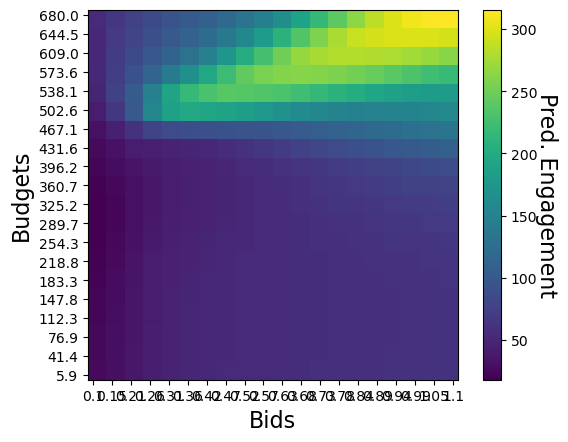

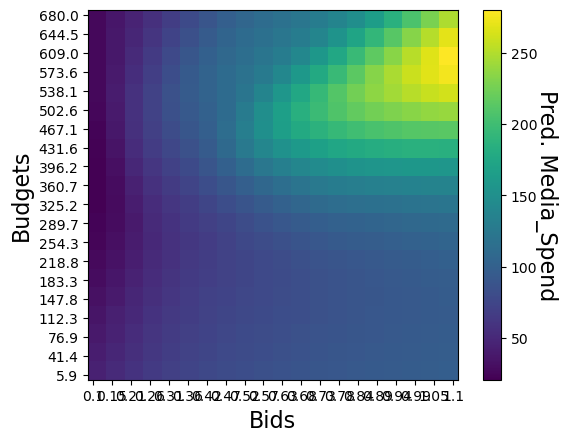

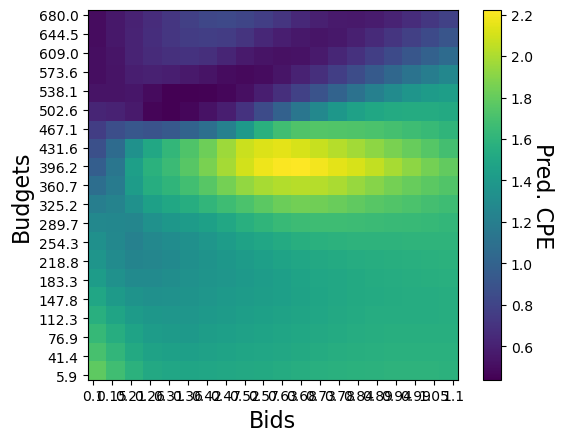

In [32]:
# Metrics on Grid
engage_pred_2d = np.reshape(engage_predictions, newshape=(n_grid,n_grid))
media_spend_pred_2d = np.reshape(spend_predictions, newshape=(n_grid,n_grid))
cpe_pred_2d = media_spend_pred_2d / engage_pred_2d

# Plot Predictions
plot_target_grid(config, engage_pred_2d, bid_budget_linspace, metric="Engagement")
plot_target_grid(config, media_spend_pred_2d, bid_budget_linspace, metric="Media_Spend")
plot_target_grid(config, cpe_pred_2d, bid_budget_linspace, metric="CPE")

# Minimum CPE
_n_budget, _n_bid = np.where(cpe_pred_2d == np.min(cpe_pred_2d))

_opt_cpe = cpe_pred_2d[_n_bid, _n_budget][0]
_opt_eng = engage_pred_2d[_n_bid, _n_budget][0]
_opt_spd = media_spend_pred_2d[_n_bid, _n_budget][0]

_opt_bid = bid_budget_linspace[0][_n_bid][0]
_opt_budget = bid_budget_linspace[1][(n_grid-1) - _n_budget][0]

# Print Results
print_results(sample_idx, _opt_cpe, _opt_eng, _opt_spd, _opt_bid, _opt_budget)

if max_media_spend:
    print("\n")
    print(f"# Max Media Spend Constraint: {max_media_spend} #")
    mask = media_spend_pred_2d < max_media_spend
    masked_cpe_pred_2d = cpe_pred_2d[mask]
    masked_min_cpe = np.min(masked_cpe_pred_2d)

    _n_bid, _n_budget = np.where(cpe_pred_2d == np.min(masked_min_cpe))
    _opt_cpe = cpe_pred_2d[_n_bid, _n_budget][0]
    _opt_eng = engage_pred_2d[_n_bid, _n_budget][0]
    _opt_spd = max_media_spend # Maximum Media Spend

    _opt_bid = bid_budget_linspace[0][_n_bid][0]
    _opt_budget = bid_budget_linspace[1][(n_grid-1) - _n_budget][0]

    print_results(sample_idx, _opt_cpe, _opt_eng, _opt_spd, _opt_bid, _opt_budget, bool(max_media_spend))
